# Optimizer Example
Jena Climate RNN example showing comparison between optimizers.
This is a regression model, using 3-hour data.

Richard Henry, 17-Jul-2024

In [1]:
#Import Libararies
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

Test Libraries

In [2]:
# Check python version
from platform import python_version
print(python_version())
#3.12.3

3.12.3


In [3]:
# Check tensorflow version
tf.__version__
#2.16.1

'2.16.2'

In [4]:
# Check keras version
tf.keras.__version__
#3.4.1

'3.4.1'

# Jena RNN
Here we compare Adam to optimizers mentioned in the paper.

Adapted from Keras Documentation.
https://www.tensorflow.org/guide/keras/working_with_rnns

In [5]:
# Load Data (Already cleaned and decimated)
df3=pd.read_csv('dataset/Jena_climate/cleanJena3.csv')

In [6]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23363 entries, 0 to 23362
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   p (mbar)       23363 non-null  float64
 1   VPact (mbar)   23363 non-null  float64
 2   Tdew (degC)    23363 non-null  float64
 3   T (degC)       23363 non-null  float64
 4   max. wv (m/s)  23363 non-null  float64
 5   NSwind         23363 non-null  float64
 6   EWwind         23363 non-null  float64
 7   year           23363 non-null  int64  
 8   month          23363 non-null  int64  
 9   day            23363 non-null  int64  
 10  hour           23363 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 2.0 MB


In [7]:
df3.describe()

,p (mbar),VPact (mbar),Tdew (degC),T (degC),max. wv (m/s),NSwind,EWwind,year,month,day,hour
count,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000,23363.000000
mean,989.216246,9.533017,4.954671,9.456338,3.533382,-0.631798,-0.415655,2012.497068,6.517399,15.713222,10.500449
std,8.353071,4.184973,6.730860,8.428081,2.339862,1.983549,1.553730,2.289905,3.448433,8.799298,6.873702
min,942.720000,0.810000,-24.800000,-22.760000,0.000000,-10.783959,-7.148867,2009.000000,1.000000,1.000000,0.000000
25%,984.200000,6.220000,0.240000,3.340000,1.760000,-1.480647,-1.372670,2010.000000,4.000000,8.000000,6.000000
50%,989.590000,8.860000,5.210000,9.440000,2.980000,-0.637933,-0.296919,2012.000000,7.000000,16.000000,12.000000
75%,994.730000,12.360000,10.080000,15.480000,4.730000,0.306138,0.432981,2014.000000,10.000000,23.000000,15.000000
max,1015.170000,28.040000,22.940000,36.460000,18.780000,7.709359,6.966350,2017.000000,12.000000,31.000000,21.000000


In [8]:
# Model / data parameters
blk_len=16*8       #Look back at 2 weeks of data
stp_len=8          #look forward 24 hours
row_len=len(df3)   #total records (last target location)
col_len=11         #total variables
bat_len=64*8       #batch size of 2 months
epo_len=32         #32 epochs
val_fra=0.2        #use 20% of data for validation
pas_len=blk_len+stp_len  #first target location
cut_len=row_len-pas_len  #last start of predictor location

In [9]:
%%time
# Reformat
y_train=df3['T (degC)'].iloc[pas_len:].to_numpy()  #pull out all the targets
#start building predictor deck
xAll=df3.to_numpy()
xTrain=np.zeros([cut_len,blk_len,col_len])
for i in range(cut_len):
    for j in range(blk_len):
            xTrain[i][j][:]=xAll[i+j][:]

CPU times: total: 2.09 s
Wall time: 2.44 s


In [10]:
#Normalize Input Data
fixMe=tf.keras.layers.Normalization()
fixMe.adapt(xTrain)

In [11]:
# Build & train model function
def model_build(myOpti):
    #Build it exactly the same every time
    tf.random.set_seed(19)
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(blk_len,col_len)),
            fixMe,
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(1,
                           activation='linear')
        ]
    )
    model.compile(loss='mean_squared_error',
                  optimizer=myOpti,
                  metrics=['mean_absolute_error'])
    myHis=model.fit(xTrain,
                    y_train,
                    batch_size=bat_len,
                    epochs=epo_len,
                    validation_split=val_fra)
    myPre=model.predict(xTrain)
    return myHis,myPre

### First Model, Adam

In [12]:
%%time
h0,p0=model_build('adam')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - loss: 135.9784 - mean_absolute_error: 9.5574 - val_loss: 76.5219 - val_mean_absolute_error: 6.9761
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - loss: 48.3910 - mean_absolute_error: 5.4731 - val_loss: 39.7497 - val_mean_absolute_error: 4.8507
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - loss: 28.6054 - mean_absolute_error: 4.1076 - val_loss: 30.5127 - val_mean_absolute_error: 4.2323
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - loss: 23.2740 - mean_absolute_error: 3.7135 - val_loss: 25.2377 - val_mean_absolute_error: 3.8291
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - loss: 20.5198 - mean_absolute_error: 3.4881 - val_loss: 22.4641 - val_mean_absolute_error: 3.5954
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - loss: 18.3319 - mean_absolute_error: 3.2954 - val_loss: 20.3932 - val_mean_absolute_error: 3.3980
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - loss: 16.3327 - mean_absolute_err

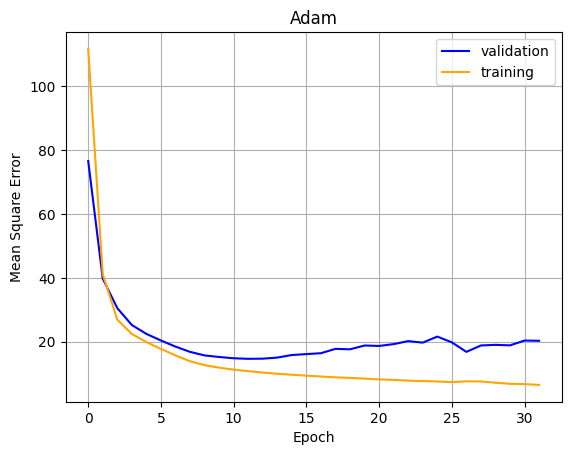

In [13]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h0.history['loss'], color='orange')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['validation','training'])
plt.title('Adam')
plt.grid()
plt.show()

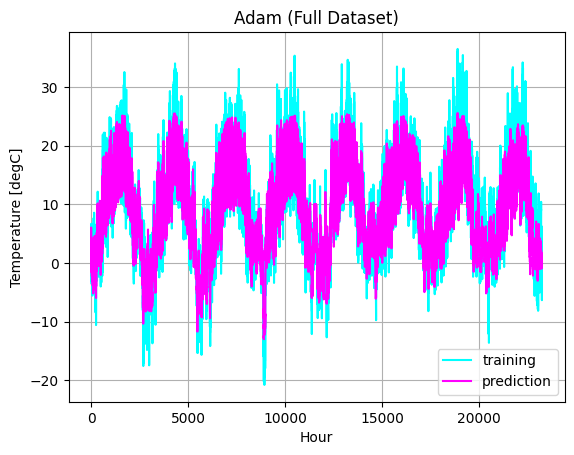

In [14]:
plt.plot(y_train, color='cyan')
plt.plot(p0.flatten(), color='magenta')
plt.ylabel('Temperature [degC]')
plt.xlabel('Hour')
plt.legend(['training','prediction'])
plt.title('Adam (Full Dataset)')
plt.grid()
plt.show()

In [15]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Year) ')
#plt.grid()
#plt.xlim([60588,69348])
#plt.show()

In [16]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Month) ')
#plt.grid()
#plt.xlim([68604,69348])
#plt.show()

In [17]:
#plt.plot(y_train, color='cyan')
#plt.plot(p0.flatten(), color='magenta')
#plt.ylabel('Temperature [degC]')
#plt.xlabel('Hour')
#plt.legend(['training','prediction'])
#plt.title('Adam (Final Week)')
#plt.grid()
#plt.xlim([69180,69348])
#plt.show()

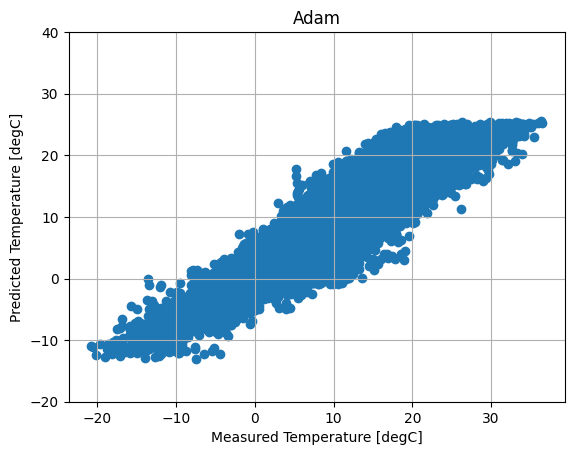

In [18]:
plt.scatter(y_train,p0.flatten())
plt.ylabel('Predicted Temperature [degC]')
plt.xlabel('Measured Temperature [degC]')
plt.title('Adam')
plt.grid()
plt.ylim([-20,40])
plt.show()

#### Commentary
Lorem Ipsum
### Second Model, AdaGrad

In [19]:
%%time
h1,p1=model_build('adagrad')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - loss: 143.8945 - mean_absolute_error: 9.9333 - val_loss: 169.5605 - val_mean_absolute_error: 11.0895
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - loss: 114.5218 - mean_absolute_error: 8.8652 - val_loss: 118.0506 - val_mean_absolute_error: 9.1600
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - loss: 75.8024 - mean_absolute_error: 6.9468 - val_loss: 86.2448 - val_mean_absolute_error: 7.5209
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - loss: 56.8253 - mean_absolute_error: 5.9037 - val_loss: 71.4619 - val_mean_absolute_error: 6.6955
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 49.4078 - mean_absolute_error: 5.4824 - val_loss: 64.5867 - val_mean_absolute_error: 6.3257
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - loss: 45.0510 - mean_absolute_error: 5.2074 - val_loss: 59.6984 - val_mean_absolute_error: 6.0528
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - loss: 41.9213 - mean_absol

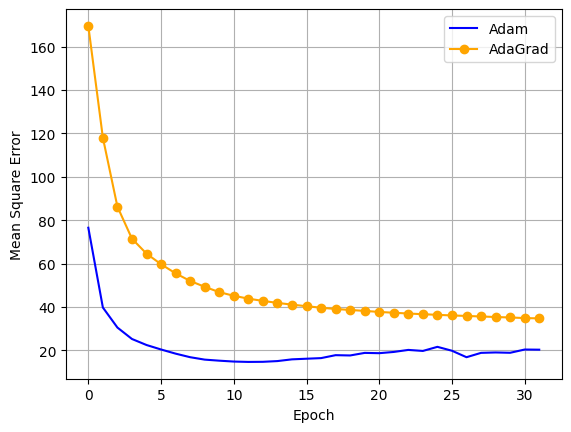

In [20]:
plt.plot(h0.history['val_loss'], color='blue')
plt.plot(h1.history['val_loss'], color='orange',marker='o')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad'])
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Third Model, SGD + Nesterov Mommentum

In [21]:
opt012=tf.keras.optimizers.SGD(momentum=0.5,
                               nesterov=True,
                               name='nSGD'
                              )

In [22]:
%%time
h2,p2=model_build(opt012)

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - loss: 56.3150 - mean_absolute_error: 5.4914 - val_loss: 21.2915 - val_mean_absolute_error: 3.5209
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - loss: 15.6608 - mean_absolute_error: 3.1232 - val_loss: 14.4854 - val_mean_absolute_error: 2.9448
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - loss: 12.3712 - mean_absolute_error: 2.7733 - val_loss: 15.6592 - val_mean_absolute_error: 3.1142
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - loss: 11.4171 - mean_absolute_error: 2.6621 - val_loss: 13.7405 - val_mean_absolute_error: 2.9161
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 10.5447 - mean_absolute_error: 2.5618 - val_loss: 12.4896 - val_mean_absolute_error: 2.7832
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - loss: 10.0311 - mean_absolute_error: 2.4990 - val_loss: 12.3444 - val_mean_absolute_error: 2.7698
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 266ms/step - loss: 9.7539 - mean_absolute_er

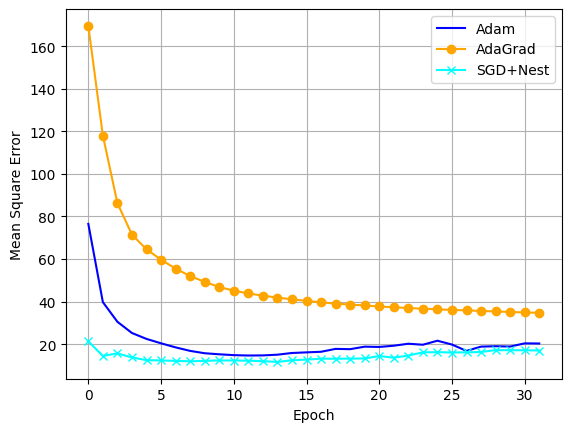

In [23]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest'])
plt.grid()
plt.show()

#### Commentary
Lorem Impsum
### Fourth Model, RMSprop

In [24]:
%%time
h3,p3=model_build('rmsprop')

Epoch 1/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - loss: 109.2197 - mean_absolute_error: 8.3285 - val_loss: 54.9055 - val_mean_absolute_error: 5.7402
Epoch 2/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - loss: 36.1368 - mean_absolute_error: 4.6025 - val_loss: 35.1408 - val_mean_absolute_error: 4.4828
Epoch 3/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - loss: 25.6592 - mean_absolute_error: 3.8800 - val_loss: 26.4009 - val_mean_absolute_error: 3.8927
Epoch 4/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 20.7194 - mean_absolute_error: 3.5052 - val_loss: 21.0745 - val_mean_absolute_error: 3.4935
Epoch 5/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - loss: 17.3008 - mean_absolute_error: 3.2114 - val_loss: 18.7858 - val_mean_absolute_error: 3.3747
Epoch 6/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - loss: 14.8246 - mean_absolute_error: 2.9897 - val_loss: 16.3902 - val_mean_absolute_error: 3.0987
Epoch 7/32
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - loss: 12.6027 - mean_absolute_

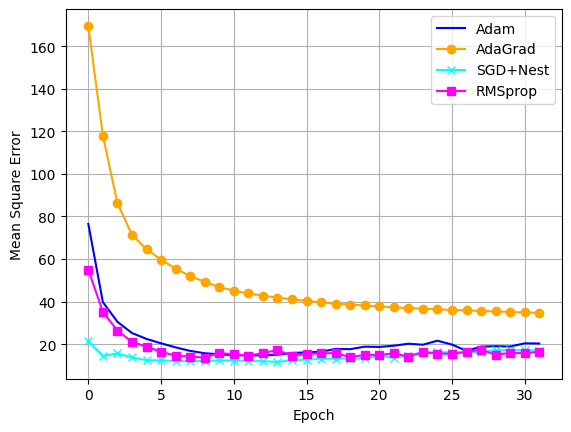

In [25]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest','RMSprop'])
plt.grid()
plt.show()

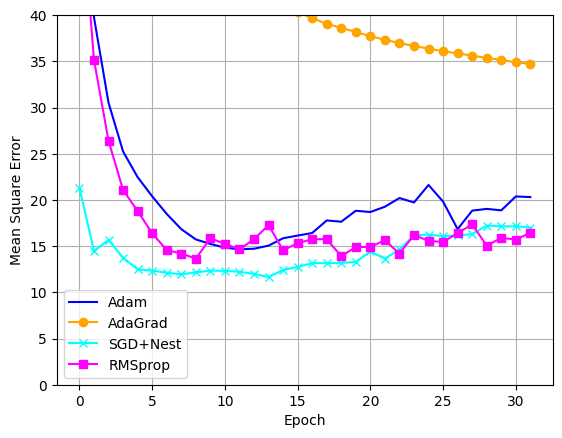

In [26]:
plt.plot(h0.history['val_loss'],color='blue')
plt.plot(h1.history['val_loss'],color='orange',marker='o')
plt.plot(h2.history['val_loss'],color='cyan',marker='x')
plt.plot(h3.history['val_loss'],color='magenta',marker='s')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Adam','AdaGrad','SGD+Nest','RMSprop'])
plt.grid()
plt.ylim([0,40])
plt.show()

#### Commentary
Lorem Ipsum
# Conclusions
Blah blah blah